In [1]:
import fasttext
from sklearn.model_selection import train_test_split
import pandas as pd
import os

llm_model = "gpt-3.5-turbo-1106"

train_df = pd.read_csv(f'../data/{llm_model}/train.csv')
test_df = pd.read_csv(f'../data/{llm_model}/test.csv')

In [2]:
os.makedirs(f'{llm_model}', exist_ok=True)
train_df.apply(lambda x: f"__label__{x[1]} {x[0]}", axis=1).to_csv(f'{llm_model}/fasttext_train.txt', index=False, header=False, quoting=3, escapechar='\\')
test_df.apply(lambda x: f"__label__{x[1]} {x[0]}", axis=1).to_csv(f'{llm_model}/fasttext_test.txt', index=False, header=False, quoting=3, escapechar='\\')

/var/folders/hm/z973kyw52lnb582wmhmh4cy80000gn/T/ipykernel_84174/3438500156.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_df.apply(lambda x: f"__label__{x[1]} {x[0]}", axis=1).to_csv(f'{llm_model}/fasttext_train.txt', index=False, header=False, quoting=3, escapechar='\\')
/var/folders/hm/z973kyw52lnb582wmhmh4cy80000gn/T/ipykernel_84174/3438500156.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_df.apply(lambda x: f"__label__{x[1]} {x[0]}", axis=1).to_csv(f'{llm_model}/fasttext_test.txt', index=False, header=False, quoting=3, escapechar='\\')


In [3]:
import matplotlib.pyplot as plt

epochs = [1, 5, 10, 25, 50, 100]
wordNgrams = [1, 2, 3]
results = []

for epoch in epochs:
    for ngram in wordNgrams:
        model = fasttext.train_supervised(input=f'{llm_model}/fasttext_train.txt', epoch=epoch, lr=1.0, wordNgrams=ngram)
        train_result = model.test(f'{llm_model}/fasttext_train.txt', k=1)
        test_result = model.test(f'{llm_model}/fasttext_test.txt', k=1)
        results.append((epoch, ngram, train_result[1], test_result[1]))

Read 3M words
Number of words:  139468
Number of labels: 5
Progress: 100.0% words/sec/thread: 2864948 lr:  0.000000 avg.loss:  0.745741 ETA:   0h 0m 0s
Read 3M words
Number of words:  139468
Number of labels: 5
Progress: 100.0% words/sec/thread: 1433990 lr:  0.000000 avg.loss:  0.754982 ETA:   0h 0m 0s
Read 3M words
Number of words:  139468
Number of labels: 5
Progress: 100.0% words/sec/thread: 1401626 lr:  0.000000 avg.loss:  0.759101 ETA:   0h 0m 0s


KeyboardInterrupt: 

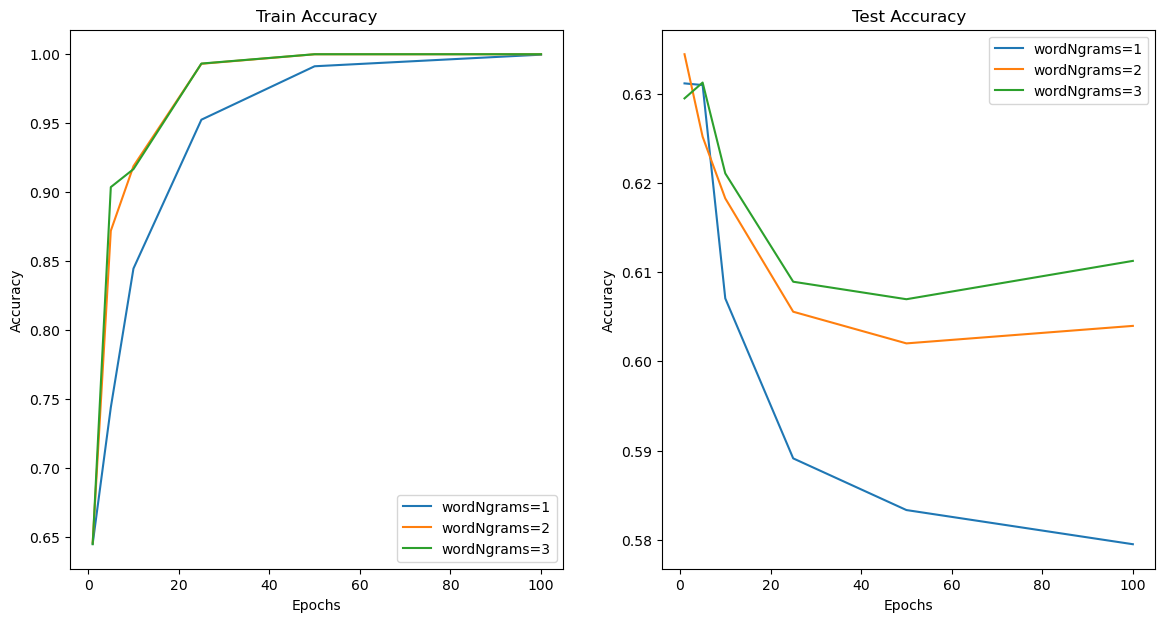

In [36]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

for ngram in wordNgrams:
    train_accuracies = [result[2] for result in results if result[1] == ngram]
    test_accuracies = [result[3] for result in results if result[1] == ngram]
    ax[0].plot(epochs, train_accuracies, label=f'wordNgrams={ngram}')
    ax[1].plot(epochs, test_accuracies, label=f'wordNgrams={ngram}')

ax[0].set_title('Train Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].set_title('Test Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()


In [4]:
# 3-gram, 1 epoch gives best result

model = fasttext.train_supervised(input=f'{llm_model}/fasttext_train.txt', epoch=1, lr=1.0, wordNgrams=3)
train_result = model.test(f'{llm_model}/fasttext_train.txt', k=1)
test_result = model.test(f'{llm_model}/fasttext_test.txt', k=1)

Read 3M words
Number of words:  139468
Number of labels: 5
Progress: 100.0% words/sec/thread: 1415545 lr:  0.000000 avg.loss:  0.755003 ETA:   0h 0m 0s


In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate predictions for the test set
test_labels, test_predictions = [], []
with open(f'{llm_model}/fasttext_test.txt') as f:
    for line in f:
        label, text = line.split(' ', 1)
        test_labels.append(label)
        test_predictions.append(model.predict(text.strip())[0][0])

# Create confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.labels, yticklabels=model.labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

ModuleNotFoundError: No module named 'seaborn'